# Transient MMS Verification for Levelset Equation

Computes the forcing function for a transient MMS test, the selected solution is designed to reach steady-state rapidly.

*Load the necessary python libraries.*

In [33]:
%matplotlib inline
import glob
from sympy import *
import numpy
import matplotlib.pyplot as plt
import pandas
init_printing()

## Define the Manufactured solution

Define the assumed (exact) solution as a fuction of x, y, and t that converges rapidly in time.

In [34]:
x,t,a,b= symbols('x t a b')
u = 1+a*exp(1/(10*t))*sin(2*pi/b*x)
u

Compute the forcing function.

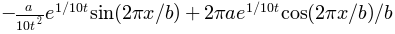

In [35]:
f = diff(u, t) + diff(u, x)
f

Build a string of the exact and forcing function to be copied to the input file (levelset_mms.i). 

*The only syntax that needs to change to make this string work with MOOSE ParsedFunction is the exponent operator.*

In [36]:
str(u).replace('**', '^') 

'a*exp(1/(10*t))*sin(2*pi*x/b) + 1'

In [37]:
str(f).replace('**', '^')

'-a*exp(1/(10*t))*sin(2*pi*x/b)/(10*t^2) + 2*pi*a*exp(1/(10*t))*cos(2*pi*x/b)/b'

Demonstrate how the solution reaches stead-state.

## Verification of Computed Solution

### Comparision of exact and compute solution at a point.

Read results files.

In [38]:
filenames = glob.glob('level_set_mms_0*.csv')
print filenames
results = []
for fname in filenames:
    results.append(pandas.DataFrame(pandas.read_csv(fname, index_col='time')))

['level_set_mms_00.csv', 'level_set_mms_01.csv', 'level_set_mms_02.csv', 'level_set_mms_03.csv', 'level_set_mms_04.csv']


Compute the exact solution at a point (0.1).

In [39]:
times = results[-1]['point'].keys()
pfunc = Lambda(t, u.subs([(x, 0.1), (a, 1), (b, 8)]))
exact = pandas.Series([pfunc(i).evalf() for i in times], index=times)

Show the compute results with the exact solution.

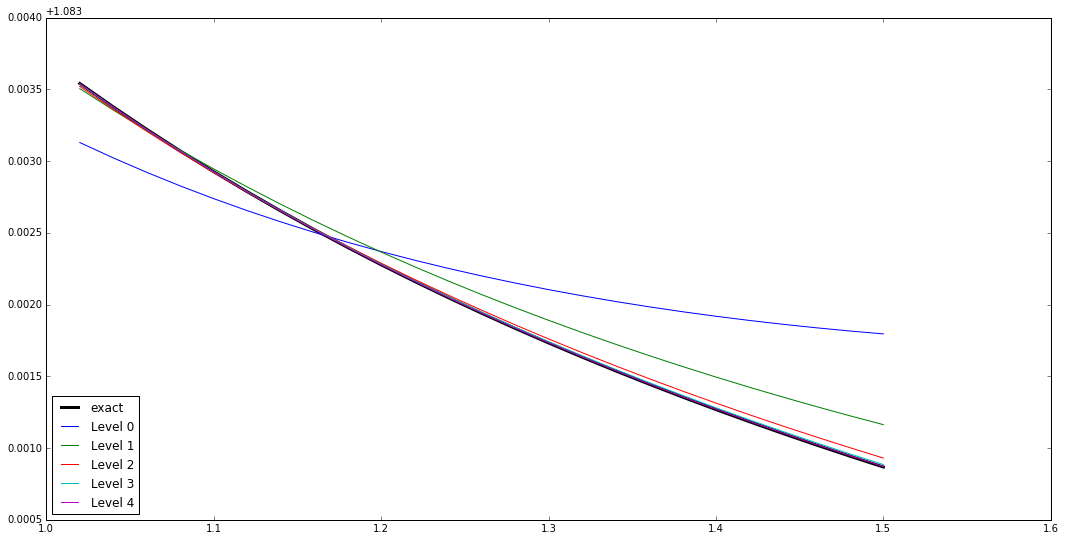

In [40]:
fig = plt.figure(figsize=(18,9))
axes = fig.add_subplot(111)
axes.plot(exact.keys(), exact.values, '-k', linewidth=3, label='exact') # pandas.Series plot method not working
for i in range(len(results)):
    x = results[i]['point'].keys()
    y = results[i]['point'].values
    axes.plot(x, y, label='Level ' + str(i))
plt.legend(loc='lower left')

### Convergence Plot

Extract error and number of dofs.

In [41]:
n = len(results)
error = numpy.zeros(n)
h = numpy.zeros(n)
for i in range(n):
    error[i] = results[i]['error'].iloc[-1]
    h[i] = 1./results[i]['h'].iloc[-1]

Fit line to data.

In [42]:
coefficients = numpy.polyfit(numpy.log10(h), numpy.log10(error), 1)
coefficients

array([-2.01097552, -0.63440881])

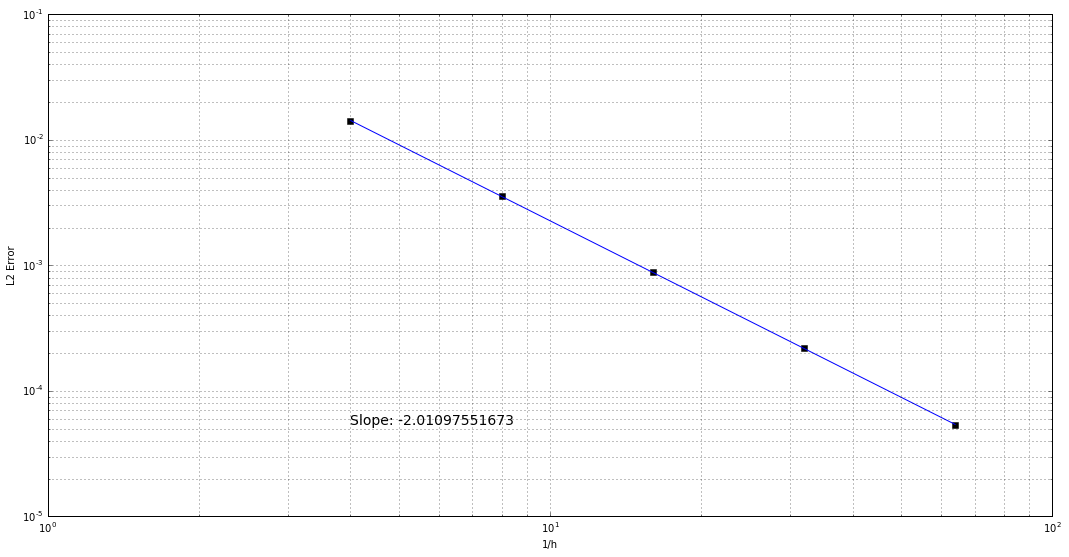

In [46]:
fig = plt.figure(figsize=(18,9))
axes = fig.add_subplot(111)
axes.plot(h, error, 'sk')
axes.set(xscale='log', yscale='log', xlabel='1/h', ylabel='L2 Error',)

polynomial = numpy.poly1d(coefficients)
axes.plot(h, pow(10, polynomial(numpy.log10(h))))
axes.grid(True, which='both')

plt.text(h[0], error[-1], 'Slope: ' + str(coefficients[0]), fontsize=14)
